# Neural Cellular Automatas for growing neural structures

## Imports

In [141]:
import numpy as np
import requests
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax import linen as nn
from flax.core.frozen_dict import freeze, unfreeze


In [8]:
# @title Cellular Automata Parameters
CHANNEL_N = 16  # Number of CA state channels
TARGET_PADDING = 16  # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🦎"  # @param {type:"string"}

EXPERIMENT_TYPE = "Regenerating"  # @param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing": 0, "Persistent": 1, "Regenerating": 2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch


In [108]:
def load_image(url, max_size=TARGET_SIZE):
    r = requests.get(url)
    img = PIL.Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
    img = np.float32(img) / 255.0
    # premultiply RGB by Alpha
    img[..., :3] *= img[..., 3:]
    return img


def load_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    url = (
        "https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true"
        % code
    )
    return load_image(url)


def to_rgba(x):
    return x[..., :4]


def to_alpha(x):
    return x[..., 3:4].clip(0.0, 1.0)


def to_rgb(x):
    # assume rgb premultiplied by alpha
    rgb, a = x[..., :3], to_alpha(x)
    return 1.0 - a + rgb


def get_living_mask(x):
    return x[:, :, :, 3:4] > 0.1
    # return nn.max_pool(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1


def make_seed(size, n=1):
    x = np.zeros([n, size, size, CHANNEL_N], np.float32)
    x[:, size // 2, size // 2, 3:] = 1.0
    return x


In [173]:
class Perception(nn.Module):
    @nn.compact
    def __call__(self, x):
        return nn.Conv(
            features=CHANNEL_N,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="SAME",
            use_bias=False,
        )(x)


class Update(nn.Module):
    @nn.compact
    def __call__(self, x):
        return nn.Sequential(
            [
                nn.Dense(features=128, use_bias=True),
                nn.relu,
                nn.Dense(features=CHANNEL_N, use_bias=True),
            ]
        )(x)


class CAModel(nn.Module):

    channel_n = CHANNEL_N
    fire_rate = CELL_FIRE_RATE
    angle = 0.0

    def setup(self):
        self.pmodel = Perception()
        self.dmodel = Update()

    @nn.compact
    def __call__(self, x, rng_key, fire_rate=None, step_size=1.0):

        pre_life_mask = get_living_mask(x)

        y = self.pmodel(x)
        dx = self.dmodel(y) * step_size
        if fire_rate is None:
            fire_rate = self.fire_rate

        update_mask = (
            jax.random.uniform(rng_key, shape=x[:, :, :, :1].shape) <= fire_rate
        )
        x += dx * update_mask.astype(jnp.float32)

        post_life_mask = get_living_mask(x)
        life_mask = pre_life_mask & post_life_mask
        return x * life_mask.astype(jnp.float32)


def get_kernel(angle=0, channel_n=CHANNEL_N):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = np.cos(angle), jnp.sin(angle)
    kernel = np.stack([identify, c * dx - s * dy, s * dx + c * dy], -1)[:, :, None, :]
    kernel = np.repeat(kernel, channel_n, axis=2)
    return kernel


def set_params(self, params, angle=0, channel_n=CHANNEL_N):
    kernel = get_kernel(angle, channel_n)
    params = unfreeze(params)
    params["params"]["pmodel"]['Conv_0']["kernel"] = kernel
    params = freeze(params)
    
    return params


In [179]:
get_kernel().shape

(3, 3, 16, 3)

In [181]:
ca_model = CAModel()
rng_key = jax.random.PRNGKey(0)
rng_key, subkey1, subkey2 = jax.random.split(rng_key, 3)
params = ca_model.init(subkey1, x=make_seed(128), rng_key=subkey2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


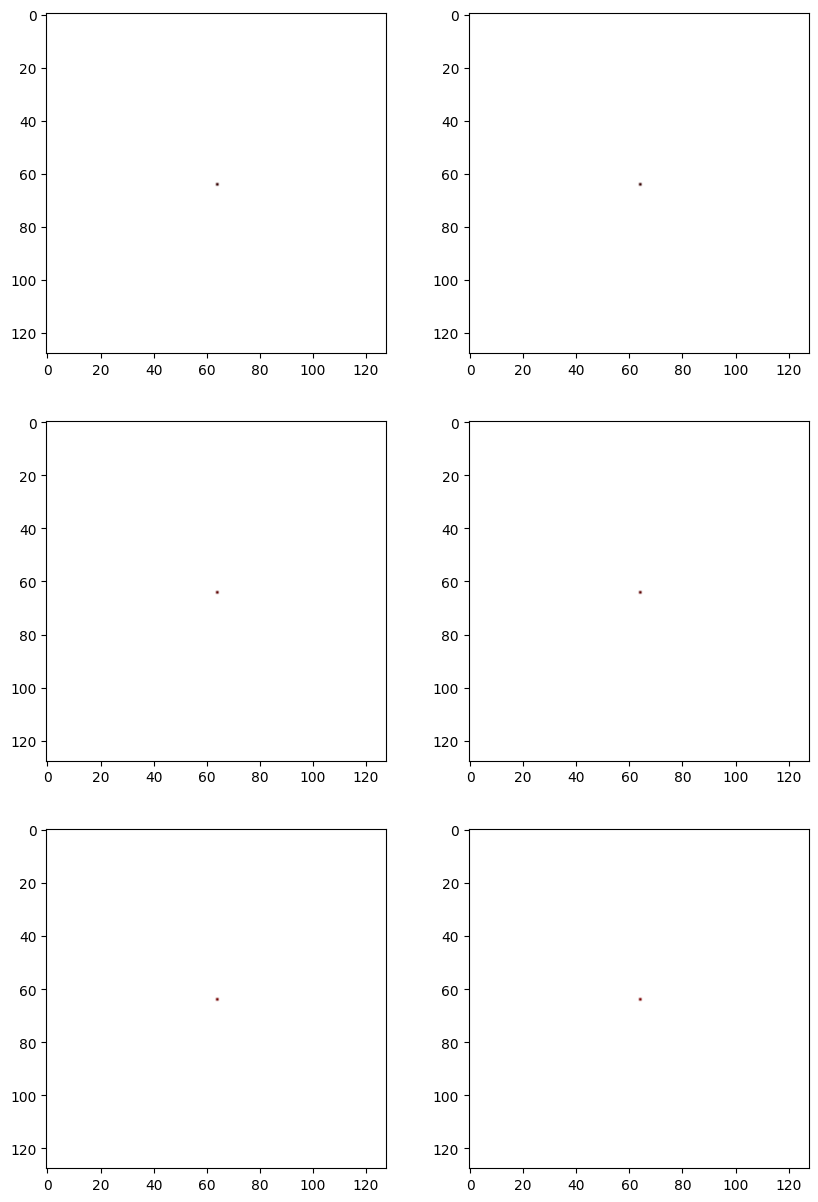

In [182]:
x = make_seed(128)
rng_key = jax.random.PRNGKey(1)
a, b = 3, 2
fig, axs = plt.subplots(a, b, figsize=(5 * b, 5 * a))
for t, ax in enumerate(axs.flatten()):
    rng_key, subkey = jax.random.split(rng_key)
    x = ca_model.apply(params, x, rng_key=subkey)
    ax.imshow(to_rgb(x[0]))
